<a href="https://colab.research.google.com/github/ebeltyukova/Neural-Network-/blob/main/Liza_cogs181_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Tue Mar 18 17:10:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print(tf.__version__)



2.18.0


# **Setup**

#### Instructions: run the “set up”, then skip all the way to the bottom and just run the “dataset preprocessing”, and then run the part labeled "function 3". i was planning on also running hyperparameters testing for elu and leaky relu after that, seeing the results and based on the best performing model, adjust layers to make it even better. i can still write code for that tho

In [4]:
pip install scikeras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import optuna

from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

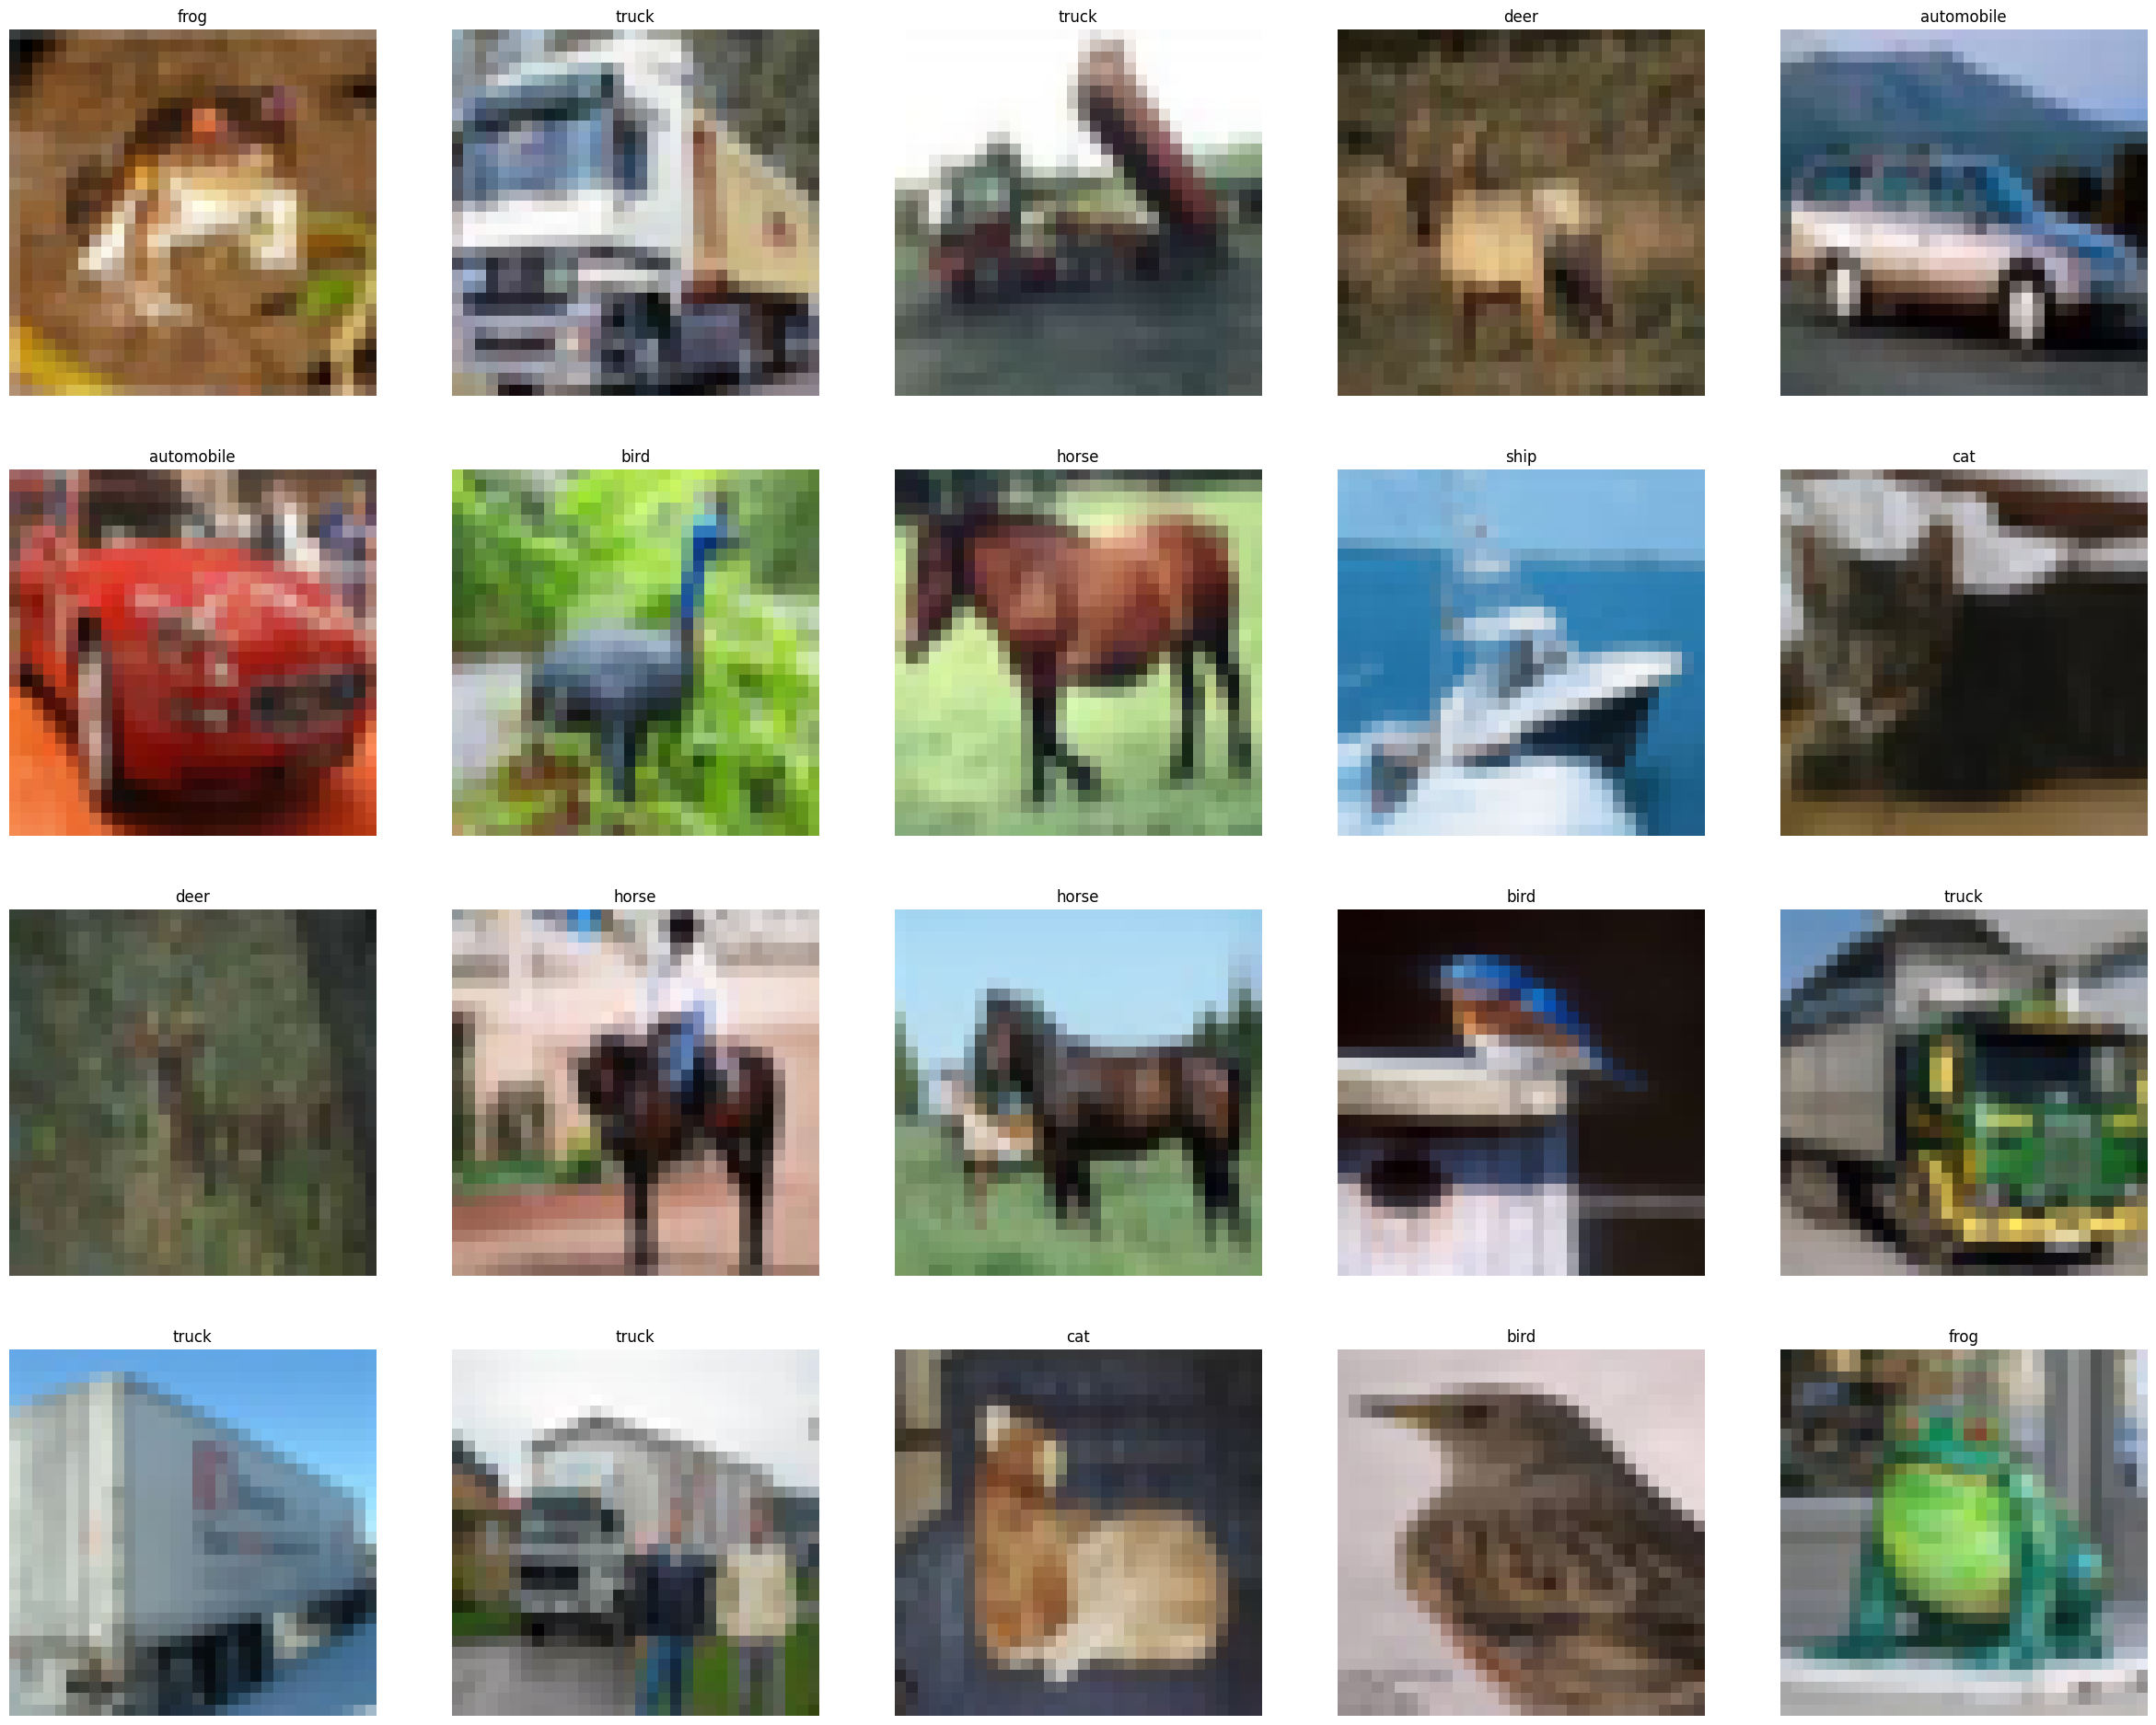

In [ ]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [4]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))

    return image,label


In [5]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)


Train size: 50000
Test size: 10000


In [6]:

train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )



# **AlexNet model with relu function. Unchanged**

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          10,2

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [ ]:
history=model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)


Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.2038 - loss: 2.3559 - val_accuracy: 0.4131 - val_loss: 1.6217
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.3589 - loss: 1.7626 - val_accuracy: 0.4868 - val_loss: 1.4320
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4406 - loss: 1.5562 - val_accuracy: 0.5183 - val_loss: 1.3260
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4887 - loss: 1.4241 - val_accuracy: 0.5515 - val_loss: 1.2371
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5308 - loss: 1.3060 - val_accuracy: 0.5901 - val_loss: 1.1562


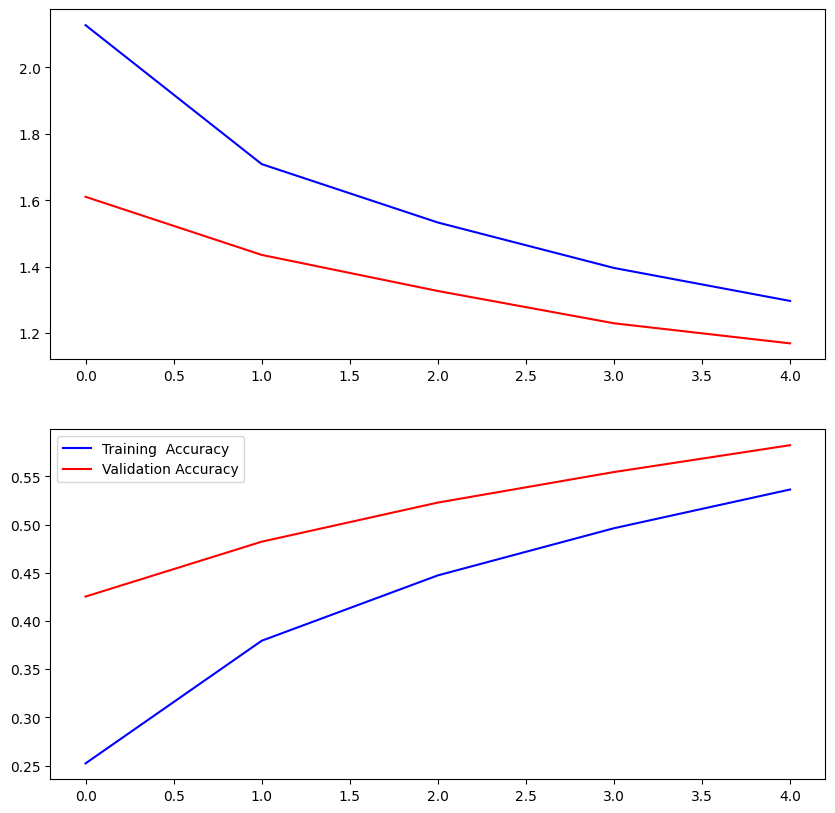

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# **AlexNet: elu function**

In [16]:
# elu, leaky relu,

## ELU

model1=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='elu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])




In [17]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 128)         │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │          10,2

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [18]:

history=model1.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2536 - loss: 2.3327 - val_accuracy: 0.5033 - val_loss: 1.3875
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4401 - loss: 1.5973 - val_accuracy: 0.5564 - val_loss: 1.2483
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5127 - loss: 1.3765 - val_accuracy: 0.5897 - val_loss: 1.1552
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5588 - loss: 1.2377 - val_accuracy: 0.6111 - val_loss: 1.1072
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5986 - loss: 1.1383 - val_accuracy: 0.6322 - val_loss: 1.0458


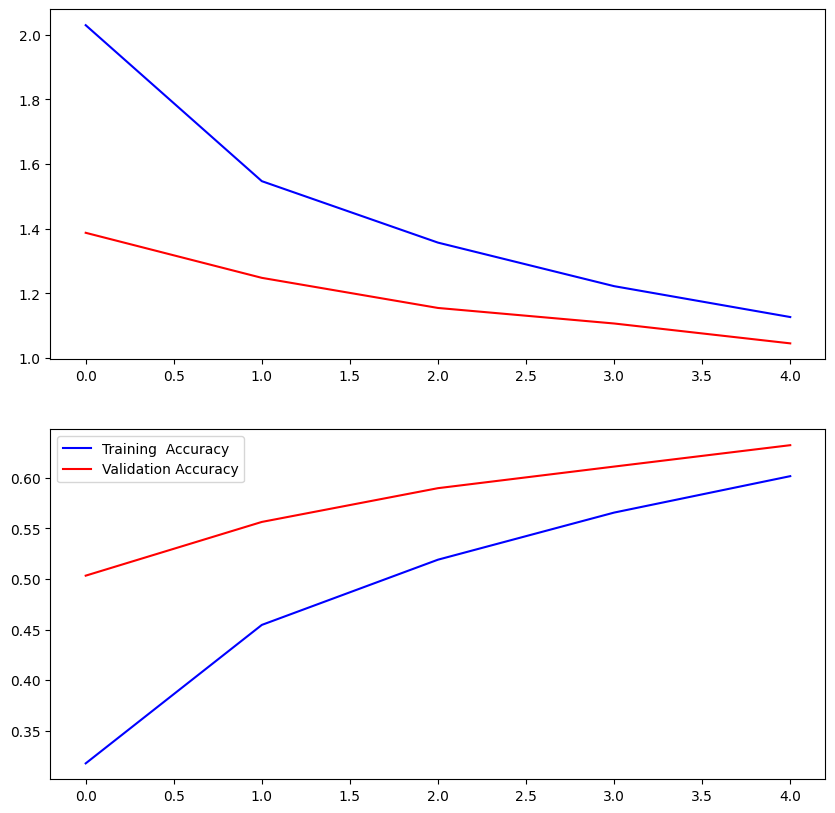

In [19]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model1.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# AlexNet: Leaky RELU

In [12]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), input_shape=(64,64,3)),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding="same"),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(pool_size=(2,2)),
keras.layers.Flatten(),
keras.layers.Dense(1024),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.Dropout(0.5),
keras.layers.Dense(1024),
keras.layers.LeakyReLU(alpha=0.3),
keras.layers.Dropout(0.5),
keras.layers.Dense(10, activation='softmax')
])

In [13]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 128)         │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │              

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [14]:
history=model2.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)


Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2435 - loss: 2.2545 - val_accuracy: 0.4926 - val_loss: 1.4431
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.4327 - loss: 1.5834 - val_accuracy: 0.5420 - val_loss: 1.2898
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5034 - loss: 1.3913 - val_accuracy: 0.5803 - val_loss: 1.1908
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5564 - loss: 1.2435 - val_accuracy: 0.6094 - val_loss: 1.1109
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5971 - loss: 1.1346 - val_accuracy: 0.6225 - val_loss: 1.0782


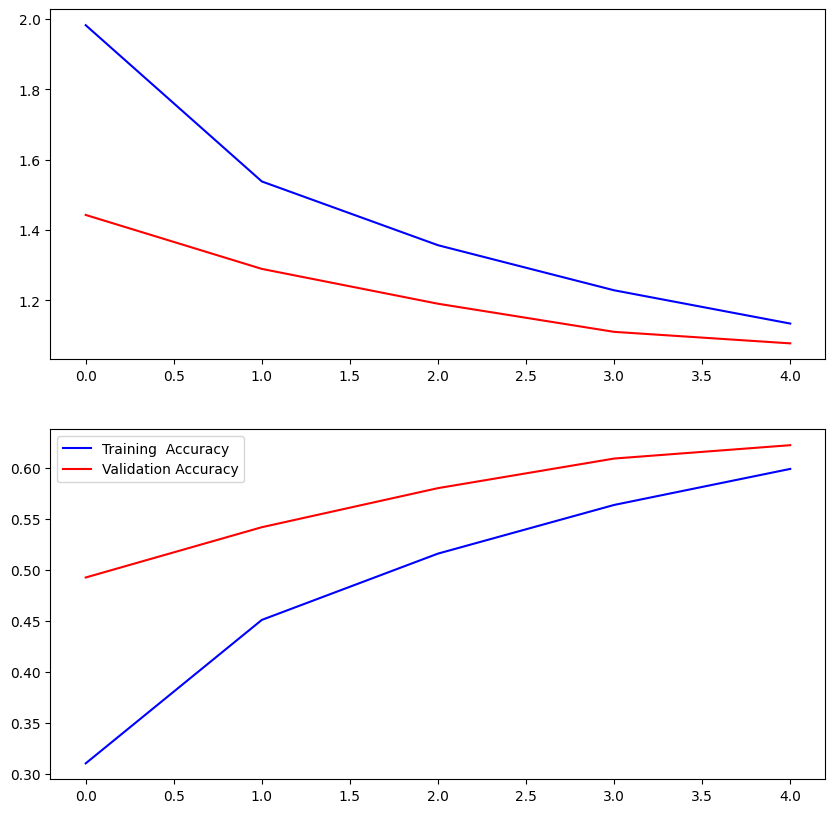

In [15]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model2.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model2.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model2.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model2.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# AlexNet: ELU, Average Pooling

In [7]:
# average pooling

model3=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='elu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='elu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model3.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 2, 2, 256)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 1, 1, 256)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │              

 Total params: 2,915,338 (11.12 MB)

 Trainable params: 2,913,034 (11.11 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [9]:
history=model3.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
    validation_freq=1
)

# change learning rate, weight decay, and batch size
# add or delete areas

# so far done: elu, relu, leaky relu; avg and max pooling for elu
# next, try learning rate

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.2762 - loss: 2.0049 - val_accuracy: 0.4316 - val_loss: 1.6011
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3886 - loss: 1.6998 - val_accuracy: 0.4711 - val_loss: 1.5002
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4306 - loss: 1.5899 - val_accuracy: 0.4920 - val_loss: 1.4308
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4535 - loss: 1.5303 - val_accuracy: 0.5144 - val_loss: 1.3655
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4742 - loss: 1.4680 - val_accuracy: 0.5185 - val_loss: 1.3474


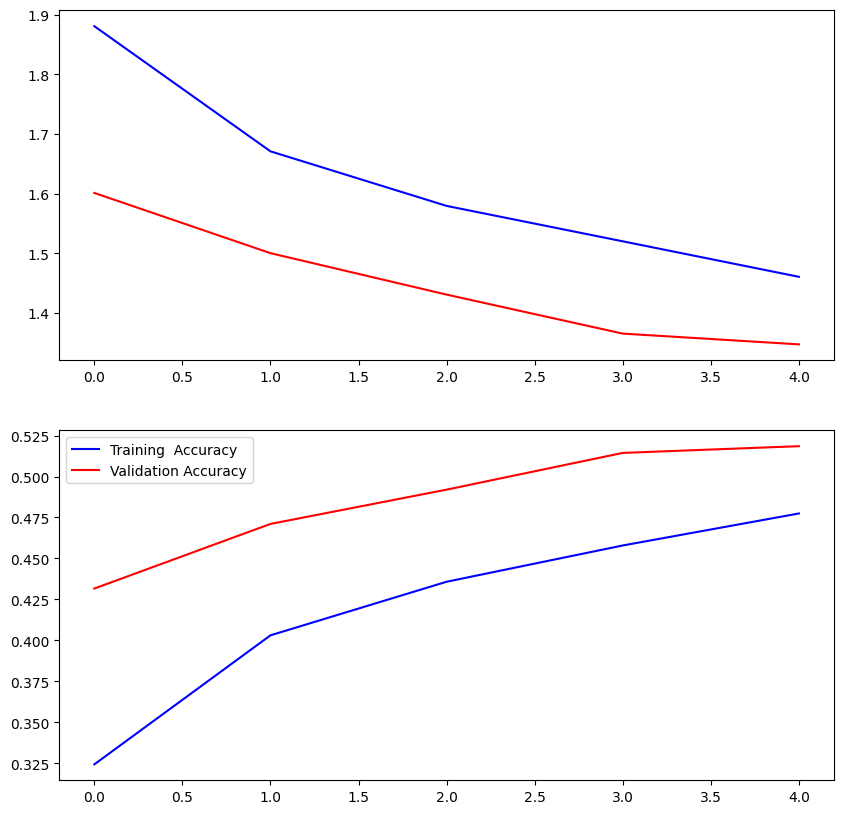

In [10]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model3.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model3.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model3.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model3.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# Testing hyperparameters using a function (AlexNet)

### Dataset preprocessing

In [8]:
# redefine dataset without pre set batching

train_ds2=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds2=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

In [9]:
train_ds_size2=tf.data.experimental.cardinality(train_ds2).numpy()
test_ds_size2=tf.data.experimental.cardinality(test_ds2).numpy()
print('Train size:',train_ds_size2)
print('Test size:',test_ds_size2)


Train size: 50000
Test size: 10000


In [10]:

train_ds2=(train_ds2
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)

         )
test_ds2=(test_ds2
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)

         )



### Function 1

In [ ]:
from tensorflow.keras import regularizers

def create_model(learning_rate, weight_decay):
    model = keras.models.Sequential([
        keras.layers.Conv2D(128, (11,11), strides=(4,4), activation='elu',
                            input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(256, (5,5), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((3,3)),
        keras.layers.Conv2D(256, (3,3), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (1,1), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (1,1), activation='elu', padding="same",
                            kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
import optuna

def objective(trial):
    # Hyperparameters to test
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create model and dataset
    model = create_model(learning_rate, weight_decay)
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return best validation accuracy
    return max(history.history['val_accuracy'])


In [ ]:

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # Test 5 combinations

[I 2025-03-18 22:57:08,313] A new study created in memory with name: no-name-9cb22096-daf1-4384-939b-a19beb7b86ab
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-03-18 22:58:27,875] Trial 0 finished with value: 0.6362000107765198 and parameters: {'learning_rate': 0.004338302164900979, 'weight_decay': 0.00018123609120285526, 'batch_size': 64}. Best is trial 0 with value: 0.6362000107765198.
[I 2025-03-18 22:59:36,115] Trial 1 finished with value: 0.5681999921798706 and parameters: {'learning_rate': 0.0011827633214098383, 'weight_decay': 0.0007265719549893194, 'batch_size': 128}. Best is trial 0 with value: 0.6362000107765198.
[I 2025-03-18 23:01:06,976] Trial 2 finished with value: 0.661

In [ ]:
print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

Best Parameters: {'learning_rate': 0.0038065217787173994, 'weight_decay': 3.944680796115359e-05, 'batch_size': 32}
Best Validation Accuracy: 0.6614999771118164


In [ ]:
# Get best hyperparameters
best_params = study.best_params

# Create final model with best hyperparameters
final_model = create_model(
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Batch datasets with best batch size
train_batched_final = train_ds.batch(best_params['batch_size'])
test_batched_final = test_ds.batch(best_params['batch_size'])

# Train final model
final_history = final_model.fit(
    train_batched_final,
    epochs=20,  # Train for more epochs with optimal parameters
    validation_data=test_batched_final,
)

# Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(test_batched_final)
print("Final Test Accuracy:", test_accuracy)


### Function 2

In [ ]:
def create_model(learning_rate, weight_decay, activation):
    model = tf.keras.Sequential()

    # Helper function returns activation layer
    def get_activation():
        if activation == 'leaky_relu':
            return layers.LeakyReLU(negative_slope=0.01)  # Use negative_slope instead of alpha
        elif activation == 'elu':
            return layers.ELU()
        else:  # ReLU
            return layers.ReLU()

    # Conv Block 1
    model.add(layers.Conv2D(128, (11,11), strides=(4,4), padding='valid',
                           kernel_regularizer=regularizers.l2(weight_decay),
                           input_shape=(64,64,3)))
    model.add(layers.BatchNormalization())
    model.add(get_activation())  # Single layer now
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 2
    model.add(layers.Conv2D(256, (5,5), padding='same',
                           kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(get_activation())
    model.add(layers.MaxPooling2D((3,3)))

    # Conv Block 3-5
    for _ in range(3):
        model.add(layers.Conv2D(256, (3,3), padding='same',
                               kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(get_activation())

    # Final pooling
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())

    # Dense layers
    for _ in range(2):
        model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(get_activation())
        model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    return model


In [ ]:
def objective(trial):
    # Hyperparameters to test
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    activation = trial.suggest_categorical('activation', ['elu', 'relu', 'leaky_relu'])

    # Create model and datasets
    model = create_model(learning_rate, weight_decay, activation)
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Training
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    return max(history.history['val_accuracy'])

In [ ]:
# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2025-03-19 21:03:07,890] A new study created in memory with name: no-name-dea4bb4b-266c-4544-a325-c14ebc5a6ba2
[I 2025-03-19 21:04:45,011] Trial 0 finished with value: 0.645799994468689 and parameters: {'learning_rate': 0.0030884436870390595, 'weight_decay': 0.0001675109769169407, 'batch_size': 32, 'activation': 'relu'}. Best is trial 0 with value: 0.645799994468689.
[I 2025-03-19 21:06:21,815] Trial 1 finished with value: 0.6377000212669373 and parameters: {'learning_rate': 0.002160653815677547, 'weight_decay': 0.007499865601426703, 'batch_size': 32, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.645799994468689.


### Function 3: best hyperparameters for RELU

In [27]:
def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        layers.Conv2D(num_filters1, (3, 3), activation='relu', padding='same',
                      input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(fc_size, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


In [28]:
def objective(trial):
    # Suggested hyperparameters
    params = {
        'num_filters1': trial.suggest_categorical("num_filters1", [32, 64, 128]),
        'num_filters2': trial.suggest_categorical("num_filters2", [64, 128, 256]),
        'fc_size': trial.suggest_categorical("fc_size", [128, 256, 512]),
        'dropout_rate': trial.suggest_float("dropout_rate", 0.2, 0.5),
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
    }

    # Batch size is handled separately
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Create model
    model = create_model(**params)

    # Batch datasets dynamically based on batch size
    train_batched = train_ds2.batch(batch_size)
    test_batched = test_ds2.batch(batch_size)

    # Train model
    history = model.fit(
        train_batched,
        epochs=5,
        validation_data=test_batched,
        verbose=0
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print best trial details
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-20 04:38:40,713] A new study created in memory with name: no-name-d16ae49a-7b43-452d-9784-317607afebcc
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Function 4: testing hyperparameters for ELU

In [ ]:
def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        layers.Conv2D(num_filters1, (3, 3), activation='elu', padding='same',
                      input_shape=(64,64,3), kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='elu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(num_filters2, (3, 3), activation='elu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(fc_size, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, activation='elu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

### Function 5: testing hyperparameters for Leaky RELU

In [ ]:


def create_model(learning_rate, num_filters1, num_filters2, fc_size, dropout_rate, weight_decay):
    model = Sequential([
        # Conv Block 1
        layers.Conv2D(num_filters1, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(64,64,3)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Conv Block 2
        layers.Conv2D(num_filters2, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Conv Block 3
        layers.Conv2D(num_filters2, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(fc_size, kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.Dropout(dropout_rate),
        layers.Dense(fc_size, kernel_regularizer=regularizers.l2(weight_decay)),
        LeakyReLU(alpha=0.3),  # Changed from ReLU
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model
